## Stone -  Estudo de dados - Clusterização

O intuito do estudo é que você explore os dados e responda as seguintes perguntas:
1. Para começar, você decidiu calcular o volume médio de vendas de cada cliente,
para classificá-los dentro de diferentes intervalos de faturamento.
* a. Apresente 3 sugestões de metodologia de classificação. Na sua opinião,
quais são as vantagens e desvantagens de cada uma das definições? Qual
é a que você usaria na prática? Por quê?
* b. Utilizando a sua definição predileta, crie uma nova variável, tier , que
determine o intervalo de faturamento médio de cada cliente. 
  * Explique a
escolha da quantidade de intervalos adotados. Dica: Utilize abreviações
como K = R$1 mil e M = R$1 milhão, por exemplo tier “100K-1M”.
1. Considerando as variáveis que você já tem à sua disposição (bem como outras
que você julgue relevante criar), produza estatísticas descritivas, incluindo
tabelas e plots, que na sua avaliação podem trazer insights interessantes para
gerar valor ao negócio.

1. Uma métrica importante para acompanhamento na indústria de meios de
pagamento é o churn da base de clientes. Tipicamente, a taxa de churn é
calculada pela razão entre a quantidade de clientes sem transacionar em um
determinado mês (mas ativos no mês anterior) e a quantidade total de clientes
que estavam ativos (i.e. transacionando) no mês anterior. Considerando a
definição de churn acima, crie uma variável indicadora churn para identificar se o
cliente está ativo ( churn = 0 ) ou deu churn ( churn = 1 ) em cada date e crie um
plot com a evolução da taxa de churn da companhia e por tier ao longo do tempo.
Quais insights você destacaria para as lideranças da companhia?


In [2]:
import pandas as pd
import numpy as np

import os
import zipfile

# Plot histagrans
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import seaborn as sns

sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Supressing warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
pd.options.display.float_format = "{:.2f}".format

### Carregar dados

In [4]:
# Create the 'data' directory if it doesn't exist
os.makedirs("case", exist_ok=True)

# Correct the path to the ZIP file
zip_path = "Case Cientista de Dados em Pricing.zip"
extract_path = "case"

# Unzip the file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


### Base Clients

In [5]:
clients_df = "./case/Estudo de dados/Clients.csv"
clients_df = pd.read_csv(clients_df)
clients_df

,client,document_type,created_at,segment
0,1,11,2022-10-01,N
1,2,11,2021-08-01,B
2,3,11,2021-07-01,B
3,4,14,2019-07-01,I
4,5,14,2018-10-01,F
...,...,...,...,...
19995,19996,11,2019-01-01,N
19996,19997,11,2021-06-01,N
19997,19998,11,2019-09-01,B
19998,19999,11,2021-10-01,B


#### Avaliar dados faltantes

In [105]:
### Avliar dados missing
clients_df.isna().sum()

client            0
document_type     0
created_at        0
segment          48
dtype: int64

In [106]:
clients_df = clients_df.dropna(subset=["segment"])
clients_df.shape

(19952, 4)

#### Valores por categoria

In [107]:
print("Total de clients:", clients_df.client.nunique())
print("Total de documentos:", clients_df.document_type.nunique())
print("Total de segments econômicos:", clients_df.segment.nunique())

Total de clients: 19952
Total de documentos: 2
Total de segments econômicos: 15


#### Métrica de total de tempo de cadastro na base

In [108]:
clients_df["created_at"] = pd.to_datetime(clients_df["created_at"])

print(
    "Identificar janela temporal de análise:",
    clients_df["created_at"].min(),
    clients_df["created_at"].max(),
)

# tempo d cadastro em meses
clients_df["idade"] = (
    (clients_df["created_at"].max() - clients_df["created_at"]).dt.days
) // 30

# Visualizar o resultado
clients_df

Identificar janela temporal de análise: 2014-08-01 00:00:00 2022-12-01 00:00:00


,client,document_type,created_at,segment,idade
0,1,11,2022-10-01,N,2
1,2,11,2021-08-01,B,16
2,3,11,2021-07-01,B,17
3,4,14,2019-07-01,I,41
4,5,14,2018-10-01,F,50
...,...,...,...,...,...
19995,19996,11,2019-01-01,N,47
19996,19997,11,2021-06-01,N,18
19997,19998,11,2019-09-01,B,39
19998,19999,11,2021-10-01,B,14


In [109]:
### Clientes cadastrados no último mês
clients_df.query("idade<= 0")

,client,document_type,created_at,segment,idade
59,60,14,2022-12-01,I,0
122,123,11,2022-12-01,I,0
131,132,14,2022-12-01,M,0
181,182,11,2022-12-01,M,0
208,209,11,2022-12-01,K,0
...,...,...,...,...,...
19814,19815,14,2022-12-01,E,0
19837,19838,11,2022-12-01,O,0
19850,19851,11,2022-12-01,I,0
19881,19882,11,2022-12-01,K,0


#### Estátisticas descritivas:

#### Avaliar distribuição do tempo de cadastro dos clientes

In [110]:
sns.set_style("darkgrid")  #

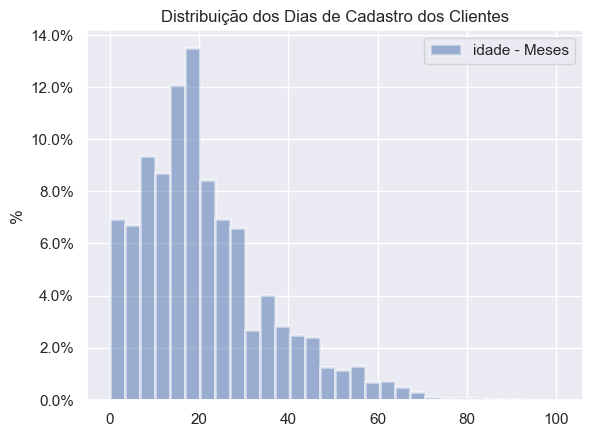

In [111]:
plt.hist(
    clients_df["idade"],
    bins=30,
    alpha=0.5,
    label="idade - Meses",
    linewidth=2,
    weights=np.ones(len(clients_df)) / len(clients_df),
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc="upper right")
plt.ylabel("%")
plt.title("Distribuição dos Dias de Cadastro dos Clientes")
plt.show()

#### Avaliar cadastro de clientes por segmento

In [112]:
## Evaluate shipper relevance per quotes share

stats_segment = (
    clients_df.groupby(["segment"], as_index=True, sort=True)
    .agg(
        {
            "client": ["size"],
            "document_type": ["nunique", "unique"],
            "idade": ["mean"],
            "created_at": ["max"],
        }
    )
    .round(2)
)

stats_segment.columns = stats_segment.columns.droplevel(1)
stats_segment = stats_segment.rename(
    {
        "client": "#_clients",
        "document_type": "#_tipo_docs",
        "created_at": "last_created_at",
    },
    axis=1,
)

stats_segment["clients_share"] = stats_segment["#_clients"] / len(clients_df) * 100
stats_segment = stats_segment.sort_values(by="#_clients", ascending=False)

stats_segment

,#_clients,#_tipo_docs,#_tipo_docs,idade,last_created_at,clients_share
segment,,,,,,
I,4191,2,"[14, 11]",20.26,2022-12-01,21.01
K,2659,2,"[11, 14]",20.66,2022-12-01,13.33
B,2408,2,"[11, 14]",19.82,2022-12-01,12.07
O,1861,2,"[11, 14]",22.04,2022-12-01,9.33
F,1653,2,"[14, 11]",22.75,2022-12-01,8.28
E,1577,2,"[14, 11]",23.13,2022-12-01,7.90
N,1554,2,"[11, 14]",21.20,2022-12-01,7.79
M,1430,2,"[14, 11]",22.30,2022-12-01,7.17
J,880,2,"[14, 11]",22.34,2022-12-01,4.41


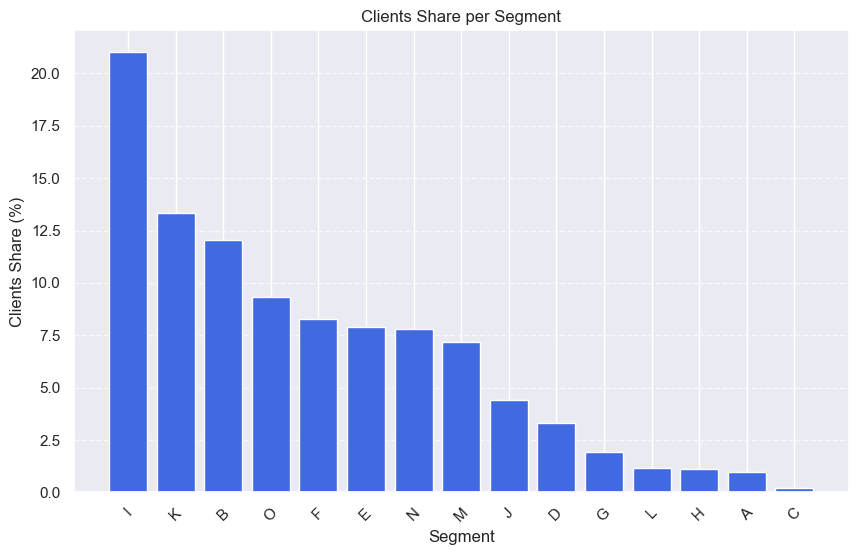

In [113]:
# Distribuição  por segmento - Gráfico de barras

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(stats_segment.index, stats_segment["clients_share"], color="royalblue")
plt.xlabel("Segment")
plt.ylabel("Clients Share (%)")
plt.title("Clients Share per Segment")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Conclusòes preliminares:

* Cliente mediano:
  * 50% concentrado em 3 segmentos: I, K, B;
  * 80% concentrado em 7 segmentos;
  * O tempo médio de cadastro na base está em cerca de 1 ano e meio a dois anos. 

* Da tabela clients_df, colunas úteis: client, segment, dias_cadastrado
  * created-at $\rightarrow$ janela temporal diferente em relação a transactions_df

In [114]:
clients_df_2 = clients_df[["client", "segment", "idade"]]
clients_df_2

,client,segment,idade
0,1,N,2
1,2,B,16
2,3,B,17
3,4,I,41
4,5,F,50
...,...,...,...
19995,19996,N,47
19996,19997,N,18
19997,19998,B,39
19998,19999,B,14


## Tabela transactions

In [6]:
transactions_df_original = "./case/Estudo de dados/Transactions.csv"
transactions_df_original = pd.read_csv(transactions_df_original)

transactions_df_original["date"] = pd.to_datetime(
    transactions_df_original["date"]
).dt.date

transactions_df_original = transactions_df_original.sort_values(by=["date", "client"])
transactions_df_original.shape

(187230, 4)

#### Combinar com informações de clientes

In [116]:
### Combinar com informações de clientes
transactions_df_original = pd.merge(
    transactions_df_original, clients_df_2, on="client", how="inner"
)

total_clientes = transactions_df_original["client"].nunique()
print("Total de clientes:", total_clientes)
transactions_df_original.shape

Total de clientes: 19952


(186716, 6)

### Avaliar periodicidade dos dados de transações

* Dados são mensais? SIm

In [117]:
transactions_df_original.date.unique()

array([datetime.date(2021, 1, 1), datetime.date(2021, 2, 1),
       datetime.date(2021, 3, 1), datetime.date(2021, 4, 1),
       datetime.date(2021, 5, 1), datetime.date(2021, 6, 1),
       datetime.date(2021, 7, 1), datetime.date(2021, 8, 1),
       datetime.date(2021, 9, 1), datetime.date(2021, 10, 1),
       datetime.date(2021, 11, 1), datetime.date(2021, 12, 1),
       datetime.date(2022, 1, 1), datetime.date(2022, 2, 1),
       datetime.date(2022, 3, 1), datetime.date(2022, 4, 1),
       datetime.date(2022, 5, 1), datetime.date(2022, 6, 1),
       datetime.date(2022, 7, 1), datetime.date(2022, 8, 1),
       datetime.date(2022, 9, 1), datetime.date(2022, 10, 1),
       datetime.date(2022, 11, 1), datetime.date(2022, 12, 1)],
      dtype=object)

### Avaliar possiveis problemas na base de dados

In [118]:
transactions_df_original.describe()

,client,sales_volume,sales_count,idade
count,186716.00,186716.00,186716.00,186716.00
mean,9662.47,10484.76,157.29,26.01
std,5606.71,32593.71,472.45,14.93
min,1.00,-151381.32,0.00,0.00
25%,4989.75,1125.00,6.00,15.00
50%,9446.50,3913.97,33.00,23.00
75%,14231.00,10242.56,138.00,35.00
max,20000.00,4185543.61,37524.00,101.00


* As estatísticas descritivas mostram discrepâncias relevantes em sales_volume e sales_count, o que indica a necessidade de ajustes seja por regras de negócio ou remoção de outliers.
  * Variância muito grande gera viés tanto para clusterização qunato para churn.

### Ajustes necesários

* verificar missing
* Sales_volume negativo -> Erro, estorno?
* 0 < Sales_volume < 1.40 -> custo mensal máquina TOM  Ton Super: 12x de R$ 1,40;
* sales_count = 0 -> como tem registro se nada foi vendido?
* Outliers (super clientes): media + 2 std = 80k;
* Excluir clientes cadastrados no último mês.

In [119]:
print(
    "Proporção de clientes com compras > 100K: "
    f"{round(transactions_df_original.query('sales_volume >= 80000').client.nunique() / total_clientes * 100, 2)}%"
)

Proporção de clientes com compras > 100K: 2.45%


In [120]:
transactions_df_original.isna().sum()

client          0
date            0
sales_volume    0
sales_count     0
segment         0
idade           0
dtype: int64

#### Excluir clients recem cadastrados

In [121]:
# Excluir cadastros no último mês
transactions_df = transactions_df_original.copy()

transactions_df = transactions_df[transactions_df["idade"] > 0]

total_clientes = transactions_df["client"].nunique()
print("Total de clientes:", total_clientes)
transactions_df.shape

Total de clientes: 19679


(186443, 6)

In [122]:
transactions_df.describe()

,client,sales_volume,sales_count,idade
count,186443.00,186443.00,186443.00,186443.00
mean,9659.84,10485.81,157.26,26.05
std,5605.08,32581.33,468.72,14.91
min,1.00,-151381.32,0.00,1.00
25%,4989.00,1126.50,6.00,15.00
50%,9442.00,3916.39,33.00,23.00
75%,14227.00,10250.30,138.00,35.00
max,20000.00,4185543.61,37524.00,101.00


#### Excluir transacoes com contagem = 0

In [123]:
transactions_df = transactions_df[transactions_df["sales_count"] > 0]
total_clientes = transactions_df["client"].nunique()
print("Total de clientes:", total_clientes)

Total de clientes: 19671


In [124]:
transactions_df.describe()

,client,sales_volume,sales_count,idade
count,186161.00,186161.00,186161.00,186161.00
mean,9658.05,10503.98,157.50,26.06
std,5605.01,32601.88,469.03,14.91
min,1.00,-151381.32,1.00,1.00
25%,4988.00,1134.36,6.00,15.00
50%,9438.00,3926.75,33.00,23.00
75%,14224.00,10263.39,138.00,35.00
max,20000.00,4185543.61,37524.00,101.00


#### Excluir receitas negativas

In [125]:
transactions_df = transactions_df.query("sales_volume > 0")

In [126]:
transactions_df.describe()

,client,sales_volume,sales_count,idade
count,185728.00,185728.00,185728.00,185728.00
mean,9657.70,10529.85,157.85,26.08
std,5604.06,32633.47,469.52,14.91
min,1.00,0.01,1.00,1.00
25%,4990.00,1148.87,7.00,15.00
50%,9438.00,3944.98,34.00,23.00
75%,14222.00,10287.99,139.00,35.00
max,20000.00,4185543.61,37524.00,101.00


### Calcular ticket medio

In [127]:
transactions_df["ticket_medio"] = (
    transactions_df["sales_volume"] / transactions_df["sales_count"]
)

### Evolução temporal de indicadores financeiros e operacionais

In [128]:
stats_time_business = (
    transactions_df.groupby(["date"], as_index=True, sort=True)
    .agg(
        {
            "client": ["nunique"],
            "sales_volume": ["mean"],
            "sales_count": ["mean"],
            "ticket_medio": ["mean"],
        }
    )
    .round(2)
)

stats_time_business.columns = stats_time_business.columns.droplevel(1)
stats_time_business

,client,sales_volume,sales_count,ticket_medio
date,,,,
2021-01-01,6150,7639.00,109.08,224.85
2021-02-01,6262,7179.68,100.68,230.31
2021-03-01,6354,7033.82,98.53,236.55
2021-04-01,6499,7224.43,101.78,233.42
2021-05-01,6693,8320.04,114.92,249.18
2021-06-01,6889,8346.83,115.82,247.11
2021-07-01,7325,9324.64,129.49,243.25
2021-08-01,7637,9392.20,133.55,259.93
2021-09-01,7986,9664.09,138.67,265.31


#### Análise temporal gráfica

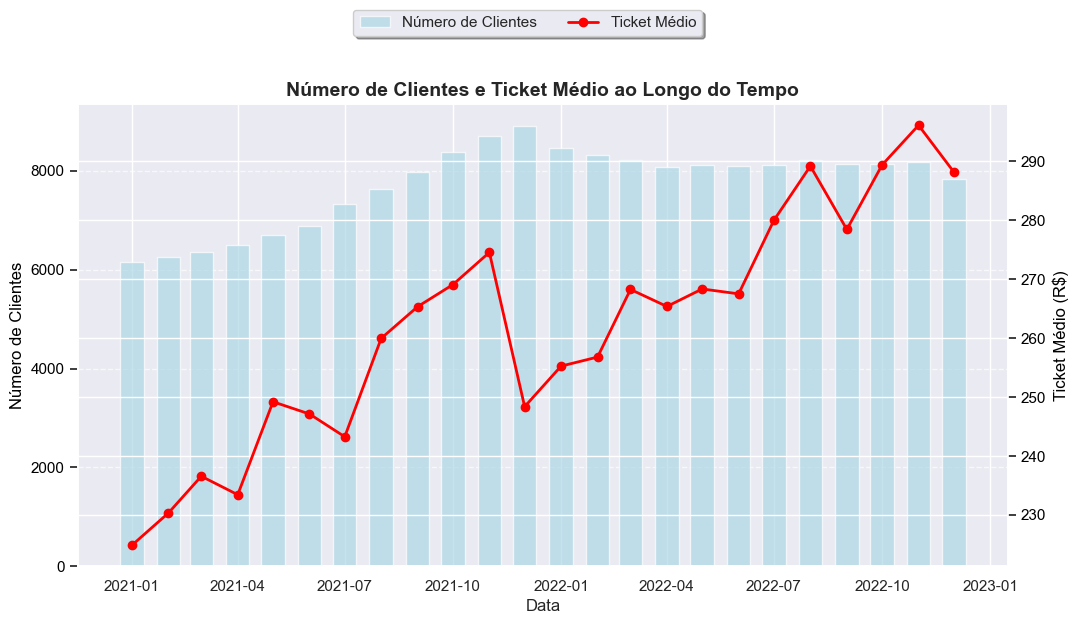

In [129]:
# Ensure date column is in datetime format
stats_time_business = stats_time_business.reset_index()
stats_time_business["date"] = pd.to_datetime(stats_time_business["date"])

# Create figure and primary Y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot (Número de Clientes)
ax1.bar(
    stats_time_business["date"],
    stats_time_business["client"],
    color="lightblue",
    alpha=0.7,
    label="Número de Clientes",
    width=20,  # Adjust width to prevent overlap
)

ax1.set_xlabel("Data")
ax1.set_ylabel("Número de Clientes", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# Create second Y-axis
ax2 = ax1.twinx()

# Line plot (Ticket Médio)
ax2.plot(
    stats_time_business["date"],
    stats_time_business["ticket_medio"],
    color="red",
    marker="o",
    linestyle="-",
    linewidth=2,
    label="Ticket Médio",
)

ax2.set_ylabel("Ticket Médio (R$)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add Legends
fig.legend(
    loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, fancybox=True, shadow=True
)

# Set Title
plt.title(
    "Número de Clientes e Ticket Médio ao Longo do Tempo",
    fontsize=14,
    fontweight="bold",
)

# Show Grid
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Show Plot
plt.show()

## Identificar outliers 

* Atentar que um cliene pode oscilar bastne em volume financeiro de um mês para o outro, o que pode prejudicar a analise. client ==125

* Valor de 1.4 foi definido por ser o plano mais barato do TOM (12 x 1,40)

In [130]:
# Identificar clientes com transacoes muito baixas
tom_df = transactions_df[(transactions_df["sales_volume"] < 1.40)]
tom_df["tom_df"] = 1
tom_df.drop_duplicates(subset=["client"], keep="first", inplace=True)
tom_df = tom_df[["client", "tom_df"]]

In [131]:
# Excluir valores elevados - 2x o desvio padrão (Regra tradicional)
prime_df = transactions_df[(transactions_df["sales_volume"] > 80000)]
prime_df["prime"] = 1
prime_df.drop_duplicates(subset=["client"], keep="first", inplace=True)
prime_df = prime_df[["client", "prime"]]

In [132]:
# Identificar clients que estao simultaneamente nos dois grupos

common_client_list = prime_df[prime_df["client"].isin(tom_df["client"])]
print(common_client_list)

        client  prime
7410      1622      1
54146    10246      1
90492    12097      1
119913     287      1
130211    6479      1
172194    9371      1
178140   13609      1
179659    5093      1
184638   19494      1


In [133]:
transactions_df.query("client ==287")

,client,date,sales_volume,sales_count,segment,idade,ticket_medio
119911,287,2021-07-01,1.00,1,J,17,1.00
119912,287,2021-08-01,68362.23,468,J,17,146.07
119913,287,2021-09-01,82191.58,556,J,17,147.83
119914,287,2021-10-01,63562.50,479,J,17,132.70
119915,287,2021-11-01,74821.27,516,J,17,145.00
119916,287,2021-12-01,68360.77,525,J,17,130.21
119917,287,2022-01-01,60978.91,485,J,17,125.73
119918,287,2022-02-01,55323.36,439,J,17,126.02
119919,287,2022-03-01,62619.60,442,J,17,141.67
119920,287,2022-04-01,67439.68,457,J,17,147.57


In [134]:
# Identificar clientes que estao nesses grupos
unique_clients = (
    pd.concat([prime_df["client"], tom_df["client"]])
    .drop_duplicates()
    .reset_index(drop=True)
)

selected_clients_df = pd.DataFrame({"client": unique_clients, "selected": 1})

selected_clients_df

,client,selected
0,96,1
1,450,1
2,534,1
3,557,1
4,639,1
...,...,...
1474,4162,1
1475,10319,1
1476,13905,1
1477,18082,1


### Remover clientes outliers da base de transações

In [135]:
transactions_df.query("client ==125")

,client,date,sales_volume,sales_count,segment,idade,ticket_medio
150609,125,2021-11-01,303304.38,4977,L,14,60.94
150610,125,2021-12-01,1047740.50,15646,L,14,66.97
150611,125,2022-01-01,929190.06,14306,L,14,64.95
150612,125,2022-02-01,865944.60,13122,L,14,65.99
150613,125,2022-03-01,687414.48,10177,L,14,67.55
150614,125,2022-05-01,561118.74,8716,L,14,64.38
150615,125,2022-06-01,791069.24,12351,L,14,64.05
150616,125,2022-07-01,545790.05,8123,L,14,67.19
150617,125,2022-08-01,205.00,11,L,14,18.64


In [136]:
transactions_df = pd.merge(
    transactions_df, selected_clients_df, on="client", how="left"
)

transactions_df_clean = transactions_df[transactions_df["selected"] != 1]

total_clientes_clean = transactions_df_clean["client"].nunique()
print("Total de clientes:", total_clientes_clean)

Total de clientes: 17965


In [137]:
transactions_df_clean.describe()

,client,sales_volume,sales_count,idade,ticket_medio,selected
count,172703.00,172703.00,172703.00,172703.00,172703.00,0.00
mean,9644.77,7484.70,125.97,26.11,261.10,NaN
std,5585.81,10034.78,268.57,14.88,658.69,NaN
min,2.00,1.40,1.00,1.00,0.26,NaN
25%,5000.00,1175.62,7.00,15.00,37.38,NaN
50%,9434.00,3829.66,32.00,23.00,85.44,NaN
75%,14201.00,9476.69,127.00,35.00,236.06,NaN
max,20000.00,79990.65,13711.00,101.00,40000.00,NaN


### Estatísticas gerais: Avaliar distribuição de algumas métricas

Estatísticas descritivas


,client,sales_volume,sales_count,idade,ticket_medio,selected
count,172703.00,172703.00,172703.00,172703.00,172703.00,0.00
mean,9644.77,7484.70,125.97,26.11,261.10,NaN
std,5585.81,10034.78,268.57,14.88,658.69,NaN
min,2.00,1.40,1.00,1.00,0.26,NaN
25%,5000.00,1175.62,7.00,15.00,37.38,NaN
50%,9434.00,3829.66,32.00,23.00,85.44,NaN
75%,14201.00,9476.69,127.00,35.00,236.06,NaN
max,20000.00,79990.65,13711.00,101.00,40000.00,NaN



Histogramas truncados


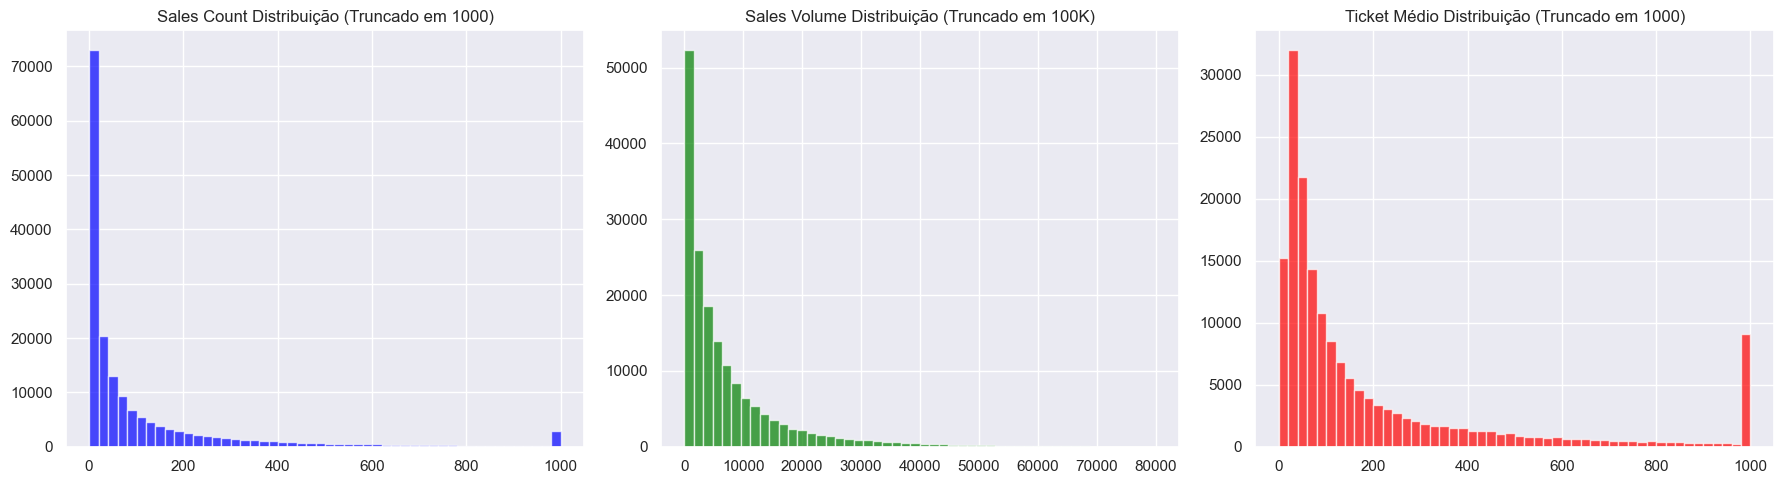

In [138]:
print("Estatísticas descritivas")
display(transactions_df_clean.describe())

print("\nHistogramas truncados")
transactions_df_hist = transactions_df_clean.copy()

# Limitar valores para melhor vizualização
transactions_df_hist["sales_count"] = transactions_df_hist["sales_count"].clip(
    upper=1000
)
transactions_df_hist["sales_volume"] = transactions_df_hist["sales_volume"].clip(
    upper=80000
)
transactions_df_hist["ticket_medio"] = transactions_df_hist["ticket_medio"].clip(
    upper=1000
)

# CCriar histogramas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

transactions_df_hist["sales_count"].hist(ax=axes[0], bins=50, color="blue", alpha=0.7)
axes[0].set_title("Sales Count Distribuição (Truncado em 1000)")

transactions_df_hist["sales_volume"].hist(ax=axes[1], bins=50, color="green", alpha=0.7)
axes[1].set_title("Sales Volume Distribuição (Truncado em 100K)")

transactions_df_hist["ticket_medio"].hist(ax=axes[2], bins=50, color="red", alpha=0.7)
axes[2].set_title("Ticket Médio Distribuição (Truncado em 1000)")

plt.tight_layout()
plt.show()

Atenção:  

* Com a exclusào de inconsistências na base de dados, foi reduzido a dispersão excesiva dos dados. 
* Porém, os dados continuam bem espalhados e concentrados em valores baixos (Distribuição assimétrica à esquerda);
  * Técnicnas mais sofisticadas de clusterização, normalmente, tem como premissa dados normalmente distribuídos. 

## Clusterização

* 3 propostas:

* Proposta 1 - Quintis:
  * Modelo simples e interpretável
  * Divide os dados em 5 grupos de mesmo tamanho com base nos percentis (quintis).
  
* Proposta 2 - K-Menas 
  * fácil compreensão e intuição: Minimização da distância euclediana para o centroíde;
  * Clusteriza baseado na densidade dos dados;
  * Total de clusters definido pela Curva do cotovelo. 
  * Permite clusters de tamanhos diferentes. 
  
* Proposta 3 - Híbrida: PCA (construção de indice) + K-Means
  * Permite utilizar outras variáveis e ponderar 
  * Bom para variavies correlacionadas. 
  * Nào detecta outliers automaticamente.
  * Cluster definidos com base nas variáveis geradas via PCA.

### Passo 1: Agrupar dados (faturamento médio de cada cliente)

Preciso agrupar por cliente e não manter a série temporal, porque o mesmo cliente pode cair em mais de um cluster, o que não faz sentido.

In [139]:
## Agrupar dados para clusterização

stats_trans_clean = (
    transactions_df_clean.groupby(["client", "segment"], as_index=True, sort=True)
    .agg(
        {
            "client": ["size"],
            "ticket_medio": ["mean", "std"],
            "sales_volume": ["mean", "std", "sum"],
            "sales_count": ["mean", "sum"],
            "date": ["min", "max"],
        }
    )
    .round(2)
)

stats_trans_clean.columns = stats_trans_clean.columns.droplevel(1)
stats_trans_clean.columns = [
    "#_mes_trans",
    "ticket_medio_avg",
    "ticket_medio_std",
    "sales_volume_avg",
    "sales_volume_std",
    "sales_volume_total",
    "sales_count_avg",
    "sales_count_total",
    "date_min",
    "date_max",
]

# Exibir o DataFrame renomeado

# Calcular tempo de vida

# Convert to datetime format
stats_trans_clean["date_min"] = pd.to_datetime(
    stats_trans_clean["date_min"], errors="coerce"
)
stats_trans_clean["date_max"] = pd.to_datetime(
    stats_trans_clean["date_max"], errors="coerce"
)

# Now calculate the month difference
stats_trans_clean["meses_venda"] = (
    (stats_trans_clean["date_max"].dt.year - stats_trans_clean["date_min"].dt.year) * 12
    + (stats_trans_clean["date_max"].dt.month - stats_trans_clean["date_min"].dt.month)
    + 1
)

stats_trans_clean["recorrencia"] = (
    stats_trans_clean["#_mes_trans"] / stats_trans_clean["meses_venda"]
)

# Get the most recent transaction date overall
overall_max_date = transactions_df_clean["date"].max()

# Calculate time since the last transaction in months
stats_trans_clean["meses_sem_venda"] = (
    overall_max_date.year - stats_trans_clean["date_max"].dt.year
) * 12 + (overall_max_date.month - stats_trans_clean["date_max"].dt.month)

# Necessário a frente para PCA
stats_trans_clean_full = stats_trans_clean.copy()

stats_trans_clean

,,#_mes_trans,ticket_medio_avg,ticket_medio_std,sales_volume_avg,sales_volume_std,sales_volume_total,sales_count_avg,sales_count_total,date_min,date_max,meses_venda,recorrencia,meses_sem_venda
client,segment,,,,,,,,,,,,,
2,B,6,114.58,40.50,1463.69,1214.73,8782.15,11.50,69,2021-08-01,2022-01-01,6,1.00,11
4,I,24,53.65,7.57,11160.19,2928.82,267844.55,215.17,5164,2021-01-01,2022-12-01,24,1.00,0
5,F,24,44.04,4.10,4775.53,2041.49,114612.61,109.08,2618,2021-01-01,2022-12-01,24,1.00,0
6,O,10,612.51,796.05,2225.06,977.45,22250.61,62.50,625,2022-03-01,2022-12-01,10,1.00,0
7,H,24,387.36,198.94,12169.66,13452.82,292071.82,26.04,625,2021-01-01,2022-12-01,24,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,N,24,35.26,5.81,6342.68,2424.47,152224.31,183.71,4409,2021-01-01,2022-12-01,24,1.00,0
19997,N,17,289.85,151.67,550.30,373.83,9355.05,1.82,31,2021-06-01,2022-10-01,17,1.00,2
19998,B,24,69.07,9.31,14518.00,15860.93,348431.92,207.42,4978,2021-01-01,2022-12-01,24,1.00,0


### Análise de correlação

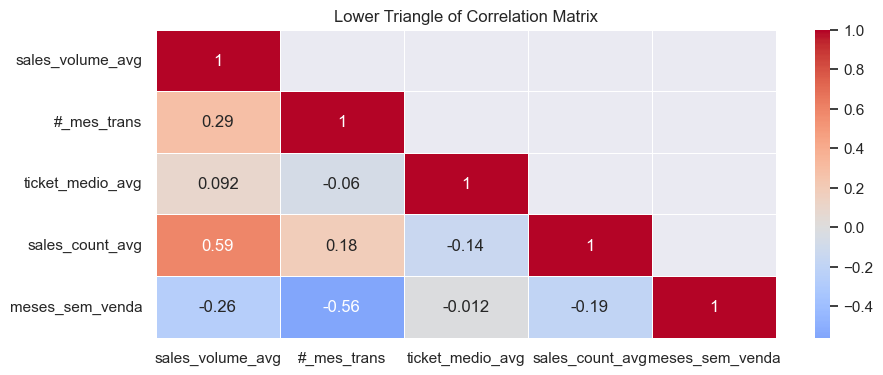

In [140]:
# Select relevant columns for correlation
stats_corr = stats_trans_clean[
    [
        "sales_volume_avg",
        "#_mes_trans",
        "ticket_medio_avg",
        "sales_count_avg",
        "meses_sem_venda",
    ]
]

# Compute correlation matrix
corrmat = stats_corr.corr()

mask = np.triu(np.ones_like(corrmat, dtype=bool), k=1)  # k=1 keeps the diagonal

# Set up the figure
plt.figure(figsize=(10, 4))

# Create heatmap with the mask
sns.heatmap(corrmat, mask=mask, annot=True, cmap="coolwarm", center=0, linewidths=0.5)

plt.title("Lower Triangle of Correlation Matrix")
plt.show()

#### Pegar infrmação relevante para definir grupos

In [141]:
df_quintil = stats_trans_clean.reset_index()
df_quintil = df_quintil[["client", "segment", "sales_volume_avg"]]
df_quintil

,client,segment,sales_volume_avg
0,2,B,1463.69
1,4,I,11160.19
2,5,F,4775.53
3,6,O,2225.06
4,7,H,12169.66
...,...,...,...
17960,19996,N,6342.68
17961,19997,N,550.30
17962,19998,B,14518.00
17963,19999,B,62.50


### Proposta 1 - Quintil

In [142]:
# Create quintile groups
df_quintil["quintil"] = pd.qcut(
    df_quintil["sales_volume_avg"], q=5, labels=[1, 2, 3, 4, 5]
)


stats_quintil = (
    df_quintil.groupby(["quintil"], as_index=True, sort=True)
    .agg({"sales_volume_avg": ["min", "max"]})
    .round(2)
)

stats_quintil.columns = stats_quintil.columns.droplevel(0)
stats_quintil.reset_index(inplace=True)
stats_quintil.rename(
    columns={"min": "min_sales_quintil", "max": "max_sales_quintil"}, inplace=True
)
stats_quintil

,quintil,min_sales_quintil,max_sales_quintil
0,1,1.50,467.50
1,2,467.57,1700.85
2,3,1703.44,3952.61
3,4,3954.36,8807.88
4,5,8811.74,70948.93


#### Atente que por necessidade de robustez, foi necessário excluir alguns clientes que apresentavam valores, muito baixo ou elevados. 

* Então esses grupos são novamene introduzidos a classificação. de acordo com sua média de volume de receita. 

In [143]:
stats_outliers = transactions_df[transactions_df["selected"] == 1]

stats_outliers = (
    stats_outliers.groupby(["client", "segment"], as_index=True, sort=True)
    .agg(
        {
            "client": ["size"],
            "ticket_medio": ["mean", "std"],
            "sales_volume": ["mean", "std", "sum"],
            "sales_count": ["mean", "sum"],
            "date": ["min", "max"],
        }
    )
    .round(2)
)

stats_outliers.columns = stats_outliers.columns.droplevel(1)
stats_outliers.columns = [
    "#_mes_trans",
    "ticket_medio_avg",
    "ticket_medio_std",
    "sales_volume_avg",
    "sales_volume_std",
    "sales_volume_total",
    "sales_count_avg",
    "sales_count_total",
    "date_min",
    "date_max",
]

# Exibir o DataFrame renomeado

# Calcular tempo de vida

# Convert to datetime format
stats_outliers["date_min"] = pd.to_datetime(stats_outliers["date_min"], errors="coerce")
stats_outliers["date_max"] = pd.to_datetime(stats_outliers["date_max"], errors="coerce")

# Now calculate the month difference
stats_outliers["meses_venda"] = (
    (stats_outliers["date_max"].dt.year - stats_outliers["date_min"].dt.year) * 12
    + (stats_outliers["date_max"].dt.month - stats_outliers["date_min"].dt.month)
    + 1
)

stats_outliers["recorrencia"] = (
    stats_outliers["#_mes_trans"] / stats_outliers["meses_venda"]
)

# Get the most recent transaction date overall
overall_max_date = transactions_df_clean["date"].max()

# Calculate time since the last transaction in months
stats_outliers["meses_sem_venda"] = (
    overall_max_date.year - stats_outliers["date_max"].dt.year
) * 12 + (overall_max_date.month - stats_outliers["date_max"].dt.month)

stats_outliers_full = stats_outliers.copy()

In [144]:
stats_outliers = stats_outliers[["sales_volume_avg"]]
stats_outliers.reset_index(inplace=True)

stats_outliers

,client,segment,sales_volume_avg
0,1,N,1665.54
1,3,B,2862.86
2,21,M,0.75
3,30,I,19.29
4,51,K,100.50
...,...,...,...
1474,19908,N,713.44
1475,19930,I,1.00
1476,19949,O,23678.35
1477,19967,M,915.75


#### Criar dois novos grupos de Quintils

In [145]:
# Criar coluna quintil
stats_outliers["quintil"] = np.nan  # Initialize with NaN

# Step 2: Get global max and min thresholds from stats_quintil
max_threshold = stats_quintil["max_sales_quintil"].max()
min_threshold = stats_quintil["min_sales_quintil"].min()

# Step 3: Assign values based on conditions
stats_outliers.loc[stats_outliers["sales_volume_avg"] < min_threshold, "quintil"] = (
    0  # Below min threshold → 0
)
stats_outliers.loc[stats_outliers["sales_volume_avg"] > max_threshold, "quintil"] = (
    6  # Above max threshold → 6
)

# Step 4: Assign quintil values from stats_quintil where sales_volume_avg is within range
for _, row in stats_quintil.iterrows():
    mask = (stats_outliers["sales_volume_avg"] >= row["min_sales_quintil"]) & (
        stats_outliers["sales_volume_avg"] <= row["max_sales_quintil"]
    )
    stats_outliers.loc[mask, "quintil"] = row["quintil"]


stats_outliers["quintil"] = stats_outliers["quintil"].astype("Int64")

stats_outliers

,client,segment,sales_volume_avg,quintil
0,1,N,1665.54,2
1,3,B,2862.86,3
2,21,M,0.75,0
3,30,I,19.29,1
4,51,K,100.50,1
...,...,...,...,...
1474,19908,N,713.44,2
1475,19930,I,1.00,0
1476,19949,O,23678.35,5
1477,19967,M,915.75,2


#### Concatenar dfs de classificação

In [146]:
combined_df = pd.concat([df_quintil, stats_outliers])

combined_df.sort_values(by="client", inplace=True)

#### Trazer as informações dos range de quintils

In [147]:
combined_df = pd.merge(combined_df, stats_quintil, on="quintil", how="left")

combined_df

,client,segment,sales_volume_avg,quintil,min_sales_quintil,max_sales_quintil
0,1,N,1665.54,2,467.57,1700.85
1,2,B,1463.69,2,467.57,1700.85
2,3,B,2862.86,3,1703.44,3952.61
3,4,I,11160.19,5,8811.74,70948.93
4,5,F,4775.53,4,3954.36,8807.88
...,...,...,...,...,...,...
19439,19996,N,6342.68,4,3954.36,8807.88
19440,19997,N,550.30,2,467.57,1700.85
19441,19998,B,14518.00,5,8811.74,70948.93
19442,19999,B,62.50,1,1.50,467.50


In [148]:
combined_df.isnull().sum()

client                 0
segment                0
sales_volume_avg       0
quintil                0
min_sales_quintil    515
max_sales_quintil    515
dtype: int64

### Passo 3:  Construçao tier

In [149]:
### Ajustar valores para tiers 0 e 6

# Step 1: Get min and max sales_quintil for quintil 1 and 5
min_quintil_1 = stats_quintil.loc[
    stats_quintil["quintil"] == 1, "min_sales_quintil"
].min()
max_quintil_5 = stats_quintil.loc[
    stats_quintil["quintil"] == 5, "max_sales_quintil"
].max()
max_sales_volume = combined_df["sales_volume_avg"].max()  # Get the max sales_volume_avg

# Step 2: Assign min and max values for quintil 0
combined_df.loc[combined_df["quintil"] == 0, "min_sales_quintil"] = 0
combined_df.loc[combined_df["quintil"] == 0, "max_sales_quintil"] = min_quintil_1

# Step 3: Assign min and max values for quintil 6
combined_df.loc[combined_df["quintil"] == 6, "min_sales_quintil"] = max_quintil_5
combined_df.loc[combined_df["quintil"] == 6, "max_sales_quintil"] = max_sales_volume

# Convert columns to float to ensure correct formatting
combined_df["min_sales_quintil"] = combined_df["min_sales_quintil"].astype(float)
combined_df["max_sales_quintil"] = combined_df["max_sales_quintil"].astype(float)

combined_df

,client,segment,sales_volume_avg,quintil,min_sales_quintil,max_sales_quintil
0,1,N,1665.54,2,467.57,1700.85
1,2,B,1463.69,2,467.57,1700.85
2,3,B,2862.86,3,1703.44,3952.61
3,4,I,11160.19,5,8811.74,70948.93
4,5,F,4775.53,4,3954.36,8807.88
...,...,...,...,...,...,...
19439,19996,N,6342.68,4,3954.36,8807.88
19440,19997,N,550.30,2,467.57,1700.85
19441,19998,B,14518.00,5,8811.74,70948.93
19442,19999,B,62.50,1,1.50,467.50


In [150]:
stats_tier = (
    combined_df.groupby(["quintil"], as_index=True, sort=True)
    .agg(
        {
            "min_sales_quintil": ["mean"],
            "max_sales_quintil": ["mean"],
        }
    )
    .round(2)
)

stats_tier.columns = stats_tier.columns.droplevel(1)
stats_tier

,min_sales_quintil,max_sales_quintil
quintil,,
0,0.00,1.50
1,1.50,467.50
2,467.57,1700.85
3,1703.44,3952.61
4,3954.36,8807.88
5,8811.74,70948.93
6,70948.93,2166505.34


In [151]:
# FUnção para construir tier conforme sugerido
def format_tier(quintil, min_val, max_val):
    """Format tier ranges with appropriate abbreviations (K for thousand, M for million)"""
    if quintil == 0:
        return "0-1.5"
    elif quintil == 1:
        return "1.50-500"
    elif quintil == 2:
        return "500-2K"
    elif quintil == 6:
        return "71K-2M"
    else:
        # Apply abbreviation logic for other quintils
        if min_val >= 1_000_000 or max_val >= 1_000_000:
            return f"{min_val/1_000_000:.0f}M-{max_val/1_000_000:.0f}M"
        elif min_val >= 1000 or max_val >= 1000:
            return f"{min_val/1000:.0f}K-{max_val/1000:.0f}K"
        else:
            return f"{min_val:.0f}-{max_val:.0f}"


# formatar quintils
stats_tier["tier"] = stats_tier.apply(
    lambda row: format_tier(
        row.name, row["min_sales_quintil"], row["max_sales_quintil"]
    ),
    axis=1,
)

stats_tier.reset_index(inplace=True)
stats_tier = stats_tier[["quintil", "tier"]]

In [152]:
df_quintil_cluster = pd.merge(combined_df, stats_tier, on="quintil", how="left")

In [153]:
df_quintil_cluster

,client,segment,sales_volume_avg,quintil,min_sales_quintil,max_sales_quintil,tier
0,1,N,1665.54,2,467.57,1700.85,500-2K
1,2,B,1463.69,2,467.57,1700.85,500-2K
2,3,B,2862.86,3,1703.44,3952.61,2K-4K
3,4,I,11160.19,5,8811.74,70948.93,9K-71K
4,5,F,4775.53,4,3954.36,8807.88,4K-9K
...,...,...,...,...,...,...,...
19439,19996,N,6342.68,4,3954.36,8807.88,4K-9K
19440,19997,N,550.30,2,467.57,1700.85,500-2K
19441,19998,B,14518.00,5,8811.74,70948.93,9K-71K
19442,19999,B,62.50,1,1.50,467.50,1.50-500


Todos os clientes tem tier definido?

In [154]:
df_quintil_cluster.isnull().sum()

client               0
segment              0
sales_volume_avg     0
quintil              0
min_sales_quintil    0
max_sales_quintil    0
tier                 0
dtype: int64

Salvar classificação de tier para análise no exercício de cluster

In [155]:
df_quintil_cluster.to_parquet("df_quintil_cluster.parquet")

### Proposta 3: Clusterização Híbrida - PCA + K-Means 

Como aqui eu excluir outliers inicialmente, preciso dessa informação desses clientes para completar a clusterização

In [156]:
stats_outliers_full.reset_index(inplace=True)
stats_trans_clean_full.reset_index(inplace=True)

In [157]:
stats_outliers_full.describe()

,client,#_mes_trans,ticket_medio_avg,ticket_medio_std,sales_volume_avg,sales_volume_std,sales_volume_total,sales_count_avg,sales_count_total,meses_venda,recorrencia,meses_sem_venda
count,1479.00,1479.00,1479.00,1221.00,1479.00,1221.00,1479.00,1479.00,1479.00,1479.00,1479.00,1479.00
mean,10293.17,8.81,247.62,236.14,32546.07,19216.20,448315.21,365.48,5113.02,9.86,0.92,6.71
std,5951.95,7.51,912.71,1233.05,83410.93,48271.80,1167015.83,1044.39,16096.44,7.84,0.18,7.19
min,1.00,1.00,0.01,0.00,0.01,0.00,0.01,1.00,1.00,1.00,0.14,0.00
25%,5011.00,2.00,9.91,8.82,24.31,279.23,71.50,1.00,3.00,3.00,0.96,0.00
50%,10378.00,6.00,55.25,28.62,1097.50,2409.88,8561.50,6.18,55.00,8.00,1.00,4.00
75%,15699.00,14.00,172.12,119.95,46437.57,26664.48,495488.94,259.50,2917.50,16.00,1.00,12.00
max,19994.00,24.00,24507.22,30967.41,2166505.34,1219331.55,28164569.43,16559.17,379583.00,24.00,1.00,23.00


In [158]:
# Concatenate the DataFrames row-wise (stacking them)
pca_df = pd.concat([stats_outliers_full, stats_trans_clean_full], axis=0).reset_index(
    drop=True
)
pca_df

,client,segment,#_mes_trans,ticket_medio_avg,ticket_medio_std,sales_volume_avg,sales_volume_std,sales_volume_total,sales_count_avg,sales_count_total,date_min,date_max,meses_venda,recorrencia,meses_sem_venda
0,1,N,3,31.59,26.96,1665.54,2173.31,4996.62,36.33,109,2022-10-01,2022-12-01,3,1.00,0
1,3,B,5,22.10,12.48,2862.86,3699.25,14314.31,114.00,570,2021-07-01,2021-11-01,5,1.00,13
2,21,M,1,0.75,NaN,0.75,NaN,0.75,1.00,1,2021-10-01,2021-10-01,1,1.00,14
3,30,I,3,3.72,2.84,19.29,29.55,57.88,3.33,10,2022-03-01,2022-05-01,3,1.00,7
4,51,K,2,100.50,140.71,100.50,140.71,201.00,1.00,2,2022-02-01,2022-03-01,2,1.00,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19439,19996,N,24,35.26,5.81,6342.68,2424.47,152224.31,183.71,4409,2021-01-01,2022-12-01,24,1.00,0
19440,19997,N,17,289.85,151.67,550.30,373.83,9355.05,1.82,31,2021-06-01,2022-10-01,17,1.00,2
19441,19998,B,24,69.07,9.31,14518.00,15860.93,348431.92,207.42,4978,2021-01-01,2022-12-01,24,1.00,0
19442,19999,B,2,62.50,38.89,62.50,38.89,125.00,1.00,2,2021-10-01,2021-11-01,2,1.00,13


#### Passo 1 - Escalonar e aplicar PCA

In [159]:
pca_df.columns

Index(['client', 'segment', '#_mes_trans', 'ticket_medio_avg',
       'ticket_medio_std', 'sales_volume_avg', 'sales_volume_std',
       'sales_volume_total', 'sales_count_avg', 'sales_count_total',
       'date_min', 'date_max', 'meses_venda', 'recorrencia',
       'meses_sem_venda'],
      dtype='object')

In [ ]:
# Step 1: Carregar dados
original_df = pca_df.copy()

# Step 2: Identificar features contínuas
features = [
    "sales_volume_avg",
    "ticket_medio_avg",
    "sales_count_avg",
    "meses_venda",
    "meses_sem_venda",
]

# Step 3: Aplicar standarização (z-score default)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(original_df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)

# Aplicar PCA - 2 componentes
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

#### Passo 2: Verificar Total de Clusters: K-Means

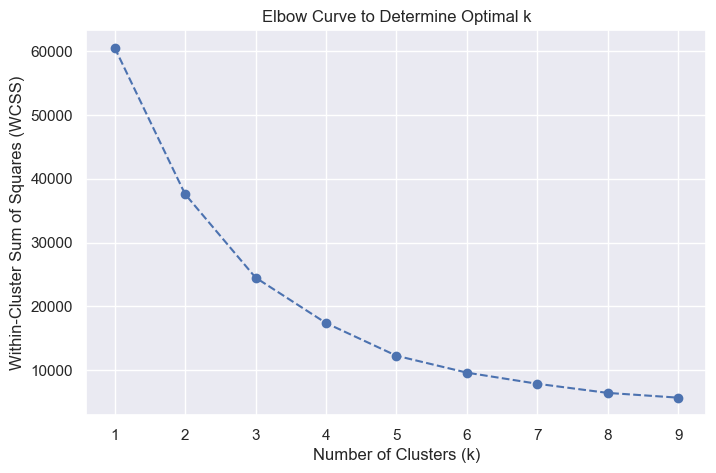

In [161]:
# Step 5: Compute Elbow Curve to Find Optimal k
k_range = range(1, 10)
wcss = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)  # Store WCSS for each k

# Step 6: Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Curve to Determine Optimal k")
plt.show()

#### Passo 3: Gerar gráficos para cluster ótimo

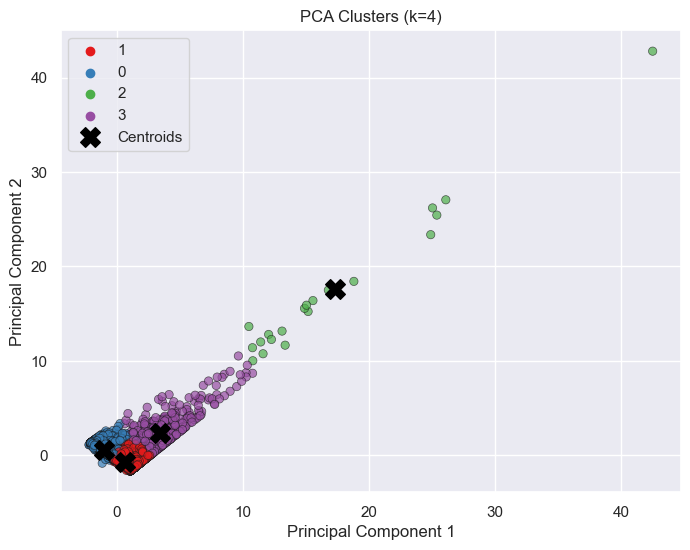

In [162]:
# Step 7: Apply K-Means with Best k (Based on Elbow Curve)
best_k = 4  # Update based on the Elbow Curve
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
pca_df["Cluster"] = kmeans.fit_predict(pca_df)  # Assign clusters

# Step 8: Merge Cluster Labels with Original Data
original_df = original_df.reset_index(drop=True)  # Ensure alignment
pca_df = pca_df.reset_index(drop=True)  # Ensure same order
original_df["Cluster"] = pca_df["Cluster"]  # Add cluster labels to the original dataset

# Step 9: Display Clients with Their Assigned Clusters
client_clusters = original_df[["client", "Cluster"]]

# Step 11: Visualize Clusters using PCA Components
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_df["PC1"],
    y=pca_df["PC2"],
    hue=pca_df["Cluster"].astype(str),  # Convert to string for categorical coloring
    palette="Set1",
    alpha=0.7,
    edgecolor="k",
)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200,
    c="black",
    marker="X",
    label="Centroids",
)  # Cluster centers
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"PCA Clusters (k={best_k})")
plt.legend()
plt.show()

             mean      min        max
Cluster                              
0         2877.90     0.01   75414.31
1         7730.95     0.81   80782.33
2       432251.56 36724.62 2166505.34
3        73132.50  7478.32  364520.85


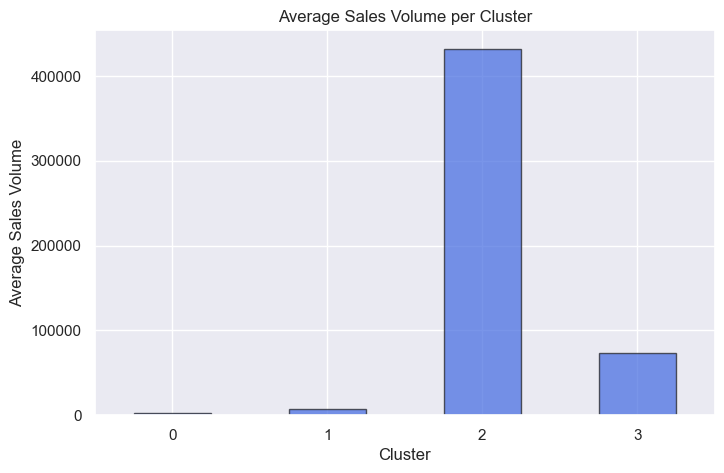

In [164]:
# Step 1: Group by Cluster and Compute Mean, Min, and Max Sales Volume
cluster_sales_stats = (
    original_df.groupby("Cluster")["sales_volume_avg"]
    .agg(["mean", "min", "max"])
    .round(2)  # Round values for better readability
)

# Step 2: Display the Sales Volume Statistics for Each Cluster
print(cluster_sales_stats)

# Step 3 (Optional): Visualize as a Bar Plot
plt.figure(figsize=(8, 5))
cluster_sales_stats["mean"].plot(
    kind="bar", color="royalblue", alpha=0.7, edgecolor="k"
)
plt.xlabel("Cluster")
plt.ylabel("Average Sales Volume")
plt.title("Average Sales Volume per Cluster")
plt.xticks(rotation=0)
plt.show()

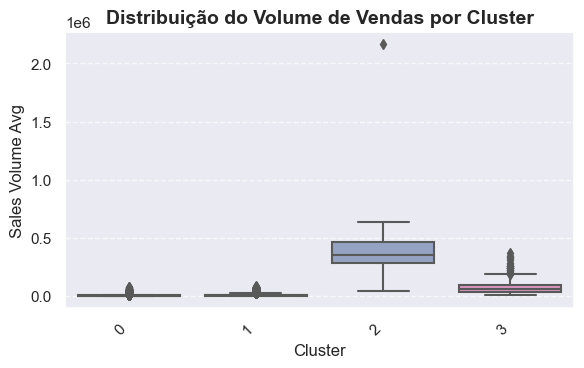

In [ ]:
# Boxplot
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(
    x=original_df["Cluster"], y=original_df["sales_volume_avg"], palette="Set2", ax=ax
)

ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Sales Volume Avg", fontsize=12)
ax.set_title(
    "Distribuição do Volume de Vendas por Cluster", fontsize=14, fontweight="bold"
)

# Rotate x-axis labels if necessary
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

#### Observações iniciais: 
* Note como o algoritmo se perde em valores muito baixos (distribuição assimétrica a esquerda)

#### Ajustes possíveis:
* 1- log-transformar sales_volume_avg
* 2 - Ampliar o numero de clusters para tentar melhor separar valores pequenos

### Proposta 3: Clusterização Híbrida - PCA + K-Means: log-transformado

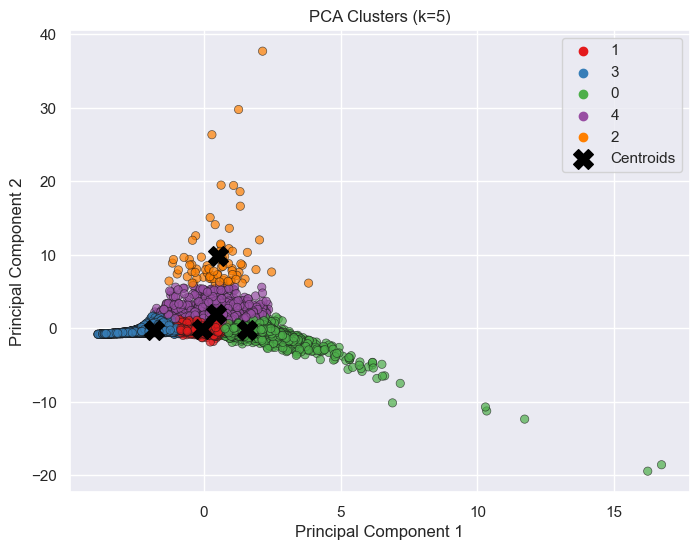

            mean     min        max
Cluster                            
0       16673.95  172.94  636864.12
1        4322.12    7.20  258896.53
2       45053.31 5047.92 2166505.34
3         869.53    0.01   26781.57
4       10277.42  942.17  364520.85


In [171]:
original_df["log_sales_volume_avg"] = np.log1p(original_df["sales_volume_avg"])

features = [
    "log_sales_volume_avg",
    "ticket_medio_avg",
    "sales_count_avg",
    "meses_venda",
    "meses_sem_venda",
]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(original_df[features])

# Aplicar PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

# Run K-Means with log-transformed sales volume
best_k = 5  # Try a slightly higher k

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
pca_df["Cluster"] = kmeans.fit_predict(pca_df)

# Step 8: Merge Cluster Labels with Original Data
original_df = original_df.reset_index(drop=True)  # Ensure alignment
pca_df = pca_df.reset_index(drop=True)  # Ensure same order
original_df["Cluster"] = pca_df["Cluster"]  # Add cluster labels to the original dataset

# Step 9: Display Clients with Their Assigned Clusters
client_clusters = original_df[["client", "Cluster"]]

# Step 11: Visualize Clusters using PCA Components
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_df["PC1"],
    y=pca_df["PC2"],
    hue=pca_df["Cluster"].astype(str),  # Convert to string for categorical coloring
    palette="Set1",
    alpha=0.7,
    edgecolor="k",
)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200,
    c="black",
    marker="X",
    label="Centroids",
)  # Cluster centers
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"PCA Clusters (k={best_k})")
plt.legend()
plt.show()


# Merge cluster labels with original dataset
original_df["Cluster"] = pca_df["Cluster"]

# Compute statistics again
cluster_sales_stats = (
    original_df.groupby("Cluster")["sales_volume_avg"]
    .agg(["mean", "min", "max"])
    .round(2)
)

print(cluster_sales_stats)

### Proposta 3: Clusterização Híbrida - PCA + K-Means: log-transformado + clusters

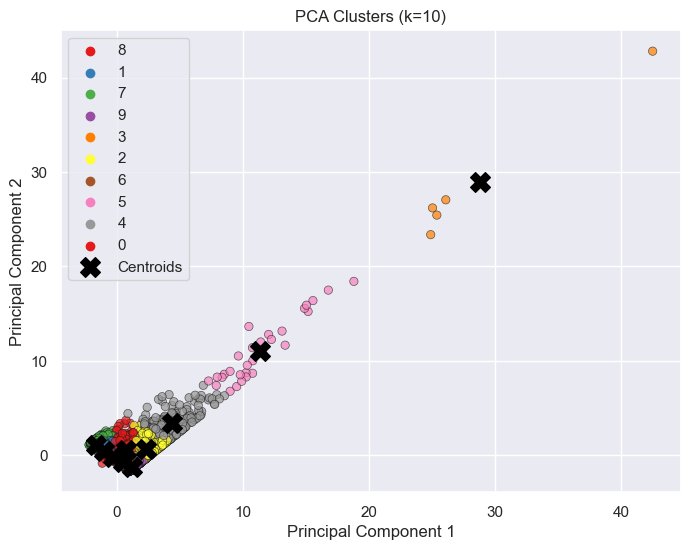

,mean,min,max
Cluster,,,
0,21280.55,534.14,97971.43
1,2623.40,0.01,58900.37
2,38906.83,4889.09,141136.45
3,740216.65,132531.90,2166505.34
4,99117.00,11928.57,364520.85
5,283591.13,36724.62,490394.71
6,5098.00,0.81,38441.89
7,2051.18,0.01,69168.01
8,3342.27,0.01,35601.70


In [172]:
original_df["log_sales_volume_avg"] = np.log1p(original_df["sales_volume_avg"])


features = [
    "sales_volume_avg",
    "ticket_medio_avg",
    "sales_count_avg",
    "meses_venda",
    "meses_sem_venda",
]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(original_df[features])

# Aplicar PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

# Run K-Means with log-transformed sales volume
best_k = 10  # Try a slightly higher k

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
pca_df["Cluster"] = kmeans.fit_predict(pca_df)

# Step 8: Merge Cluster Labels with Original Data
original_df = original_df.reset_index(drop=True)  # Ensure alignment
pca_df = pca_df.reset_index(drop=True)  # Ensure same order
original_df["Cluster"] = pca_df["Cluster"]  # Add cluster labels to the original dataset

# Step 9: Display Clients with Their Assigned Clusters
client_clusters = original_df[["client", "Cluster"]]

# Step 11: Visualize Clusters using PCA Components
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_df["PC1"],
    y=pca_df["PC2"],
    hue=pca_df["Cluster"].astype(str),  # Convert to string for categorical coloring
    palette="Set1",
    alpha=0.7,
    edgecolor="k",
)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200,
    c="black",
    marker="X",
    label="Centroids",
)  # Cluster centers
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"PCA Clusters (k={best_k})")
plt.legend()
plt.show()


original_df["Cluster"] = pca_df["Cluster"]


cluster_sales_stats = (
    original_df.groupby("Cluster")["sales_volume_avg"]
    .agg(["mean", "min", "max"])
    .round(2)
)

cluster_sales_stats

### Conclusões:

* Devido a distribuiçõ assimétrica e concentrada em baixos valores:
  * O melhor modelo de clusterização foi a de quintils. 
  * Apenas de não ser uma técnica sofisticada em termos de AI, é a que  retrata melhor a separação entre os dados, em especial, quando se trata dedaods muito concentrados